## Imports

In [10]:
## Link: https://github.com/WJMatthew/WESAD/blob/master/data_wrangling.py
%load_ext autoreload
%autoreload 2

import os
import re
import pickle
import numpy as np
import pandas as pd
import seaborn as sns
import scipy.signal as scisig
from scipy.signal import find_peaks
import matplotlib.pyplot as plt
import matplotlib as mpl
import heartpy as hp
import biosppy
import neurokit2 as nk
from heartpy.datautils import *
from heartpy.peakdetection import *
mpl.rcParams['agg.path.chunksize'] = 10000
from scipy import stats
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, accuracy_score
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.model_selection import cross_val_score, cross_val_predict
from sklearn.inspection import PartialDependenceDisplay
from sklearn.inspection import partial_dependence
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from sklearn import tree
from sklearn.ensemble import AdaBoostClassifier
from sklearn.neighbors import NearestNeighbors
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neighbors import NeighborhoodComponentsAnalysis
from sklearn.pipeline import Pipeline
import csv 
from multiprocessing import Pool

import warnings
warnings.filterwarnings('ignore')
from fb_models import *
from datetime import datetime
import logging
now = datetime.now().strftime('%Y-%m-%d-%H-%M%p')

logging.basicConfig(level=logging.INFO, filename='logs/'+now+'.log', force=True)



The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Feature Extraction

Features coded:

ECG: mean, std, min, max, bpm, ibi, sdnn, sdsd, rmssd, pnn20, pnn50, 


PPG/BVP: mean, std, min, max, peak_freq

TEMP:mean, std, min, max, drange, slope

RESP: mean, std, min, max, rate; Inh: mean, std; Exh: mean, std, I/E


EDA: mean, std, min, max, slipe, drange; SCR: mean, std, min, max; SCL: mean, std, min, max

ACC x,y,z; chest, wrist:  mean, std, min, max, abs_integral, peak_freq
Acc net: mean, std, min, max, abs_integral, peak_freq


Features not coded yet:


To replicate this study with similar modalities to RADWear, I will drop the following signals: EDA_c, EMG, TEMP_C

## Parameters

In [11]:
# E4 (wrist) Sampling Frequencies
fs_dict = {
    'ACC': 32,
    'BVP': 64,
    'EDA': 4,
    'TEMP': 4,
    'label': 700,
    'Resp': 700,
    'ECG': 700,
    'chest': 700,
}
# Window size
WINDOW_IN_SECONDS = 60
stride = 1

# Labels
label_dict = {'baseline': 1, 'stress': 2, 'amusement': 0}
# Int to label mappings
int_to_label = {1: 'baseline', 2: 'stress', 0: 'amusement'}
# Feature names
feat_names = None
# Where to save the data
loadPath = '/mnt/d/Users/alkurdi/data/WESAD'
loadPath_GN = '/mnt/d/Users/alkurdi/data/GN-WESAD'
# Where to get the data
subject_feature_path = '/subject_feats'
fb_model_list = ['DT', 'RF', 'SVM', 'LDA', 'KNN', 'AB']

if not os.path.exists(loadPath):
    os.makedirs(loadPath)
if not os.path.exists(loadPath + subject_feature_path):
    os.makedirs(loadPath + subject_feature_path)

We want to reduce modalities in WESAD data such that it matches RADWear modalities. 

In [12]:
# Data import
def read_n_reduce(path):
    df = pd.read_csv(path, index_col=0)
    df = df.drop(columns=['subject'], axis=1)
    pd.set_option('display.max_columns', None)
    # We want to drop columns in df that are not in RADWear to match modalities.
    # drop _c columns
    columns_list = df.columns.tolist()
    drop_list = []
    # df.drop(columns=['Resp_C'])
    for column in columns_list:
        if (
            'EMG' in column
            or 'EDA_C' in column
            or 'Temp_C' in column
            or 'TEMP_C' in column
            or 'SCR_C' in column
            or 'SCL_C' in column
        ):
            drop_list.append(column)

    reduced_df = df.drop(columns=drop_list)
    df = reduced_df
    return df


df = read_n_reduce(loadPath + subject_feature_path + '/oct5_feats4.csv')

## Generate correlation between features and labels

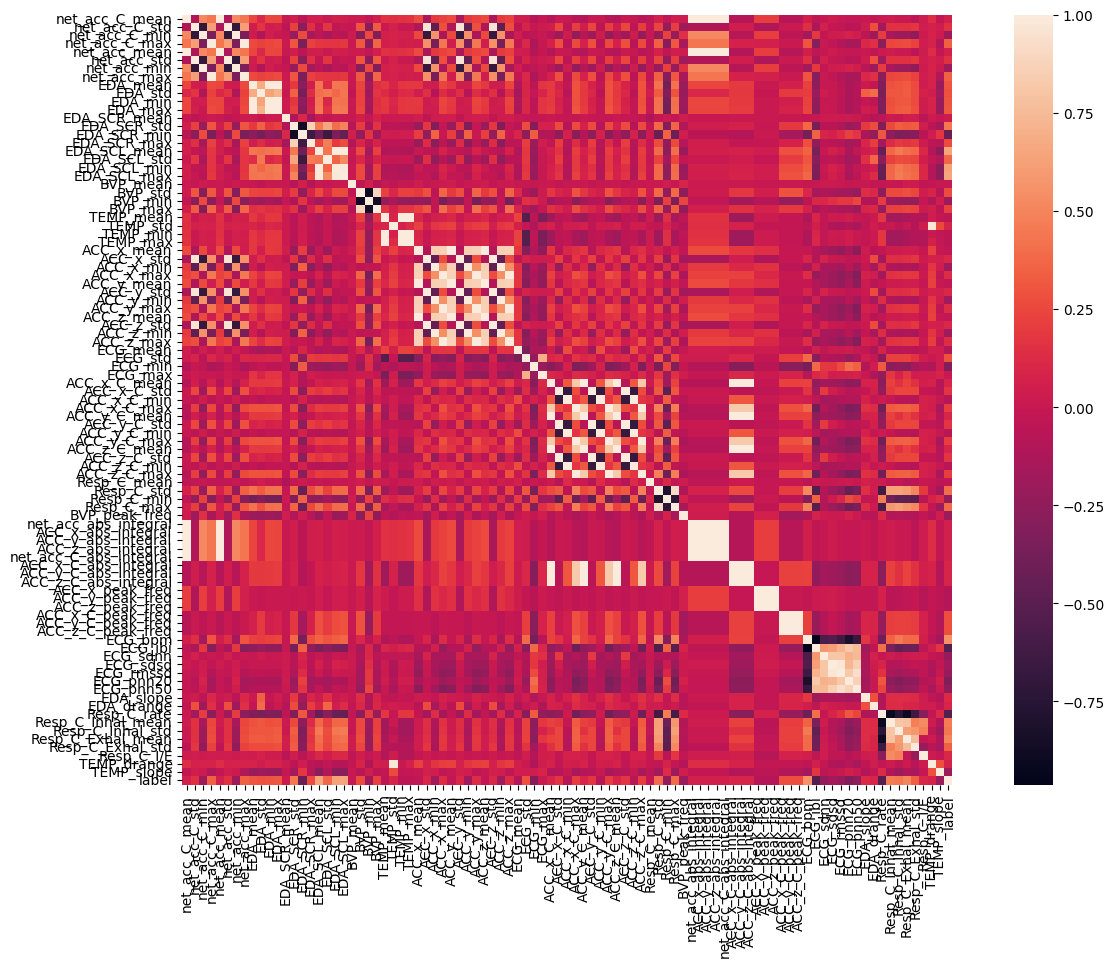

In [13]:
vals = abs(df.corr()['label']).sort_values(ascending=False)
if False:
    for i in range(len(vals)):
        print(vals.index[i], vals[i])

corr = df.corr()
plot_corr = True
if plot_corr:
    plt.figure(figsize=(16, 10))
    sns.heatmap(corr, xticklabels=True, yticklabels=True, square=True)

In [14]:
# df = df.loc[:, df.columns != 'Resp_C_rate'] #I don't know why this is here.

features = df.loc[:, df.columns != 'label'].columns
print_feats_list = False
if print_feats_list:
    for ft_idx in range(len(features)):
        print(features[ft_idx], ft_idx)

## split data into train and test set

In [15]:
X = df.drop('label', axis=1).values
y = df['label'].values
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

# Modeling

## Cross Validation

### K-Fold Cross Validation

### Leave-One-Out Cross Validation

# Models 

The models will be included in this study are: 

DT, RF, SVM, AB, LDA and kNN. 

Completed: LDA, RF, SVM, AB, DT, kNN 

Incomplete: NaN 

## Linear Discriminant Analysis

In [16]:
start_time = time()
lda_baseline_acc = run_lda(X_train, X_test, y_train, y_test)
print("--- %s seconds ---" % (time() - start_time))

--- 0.007803440093994141 seconds ---


### Feature Importance (Top 20)

## Random Forest Classifier

In [17]:
start_time = time()
rf_baseline_acc = run_rf(X_train, X_test, y_train, y_test)

print("--- %s seconds ---" % (time() - start_time))


--- 0.1507878303527832 seconds ---


### Feature Importance (Top 20)

fig, ax = plt.subplots(figsize=(12, 5))
forest_importances[:20].plot.barh(ax=ax)
ax.set_title("Feature importances using MDI")
ax.set_ylabel("Mean decrease in impurity")
fig.tight_layout()

## Support Vector Machine

### Linear SVM

In [18]:
# measure time to run

start_time = time()
svm_baseline_acc = run_svm(X_train, X_test, y_train, y_test)
print("--- %s seconds ---" % (time() - start_time))
# print(svm_baseline_acc)
svm2_baseline_acc = run_svm(
    X_train, X_test, y_train, y_test, C=0.9
)  # linear svm lambda 2
# print(svm2_baseline_acc)

--- 0.026853561401367188 seconds ---


## Adaboost 

In [18]:
# measure time to run

start_time = time()
ab_baseline = run_ab(X_train, X_test, y_train, y_test)
print("--- %s seconds ---" % (time() - start_time))

--- 0.17940926551818848 seconds ---


## Decision Tree 

In [19]:
# measure time to run

start_time = time()
dt_baseline_acc = run_dt(X_train, X_test, y_train, y_test)
print("--- %s seconds ---" % (time() - start_time))
print('decision tree baseline accuracy: ' + str(dt_baseline_acc))

--- 0.017389535903930664 seconds ---
decision tree baseline accuracy: {'Accuracy': 0.8706896551724138, 'Precision': 0.8706896551724138, 'Recall': 0.8706896551724138, 'F1 Score': 0.8706896551724138, 'Confusion Matrix': array([[13,  7,  0],
       [ 6, 61,  1],
       [ 1,  0, 27]]), 'Classification Report': '              precision    recall  f1-score   support\n\n           0      0.650     0.650     0.650        20\n           1      0.897     0.897     0.897        68\n           2      0.964     0.964     0.964        28\n\n    accuracy                          0.871       116\n   macro avg      0.837     0.837     0.837       116\nweighted avg      0.871     0.871     0.871       116\n'}


### Feature Importance (Top 20)

## k-Nearest Neighbors 

In [20]:
# measure time to run

start_time = time()
knn_baseline_acc = run_knn(X_train, X_test, y_train, y_test)
print("--- %s seconds ---" % (time() - start_time))

--- 0.03954672813415527 seconds ---


# Adding Noise

## Signal to Noise Ratio

For a non-constant signal $S$ and noise $N$, the signal to noise ratio is defined as the following:
$$ SNR = \frac{\mathbb{E}[S^2]}{\mathbb{E}[N^2]} $$

The expected value $\mathbb{E}[X]$ of any continuous random variable $X$ is $\int_{-\infty}^{\infty} x p(x) dx $, where $p(x)$ is its associated probability density function.

For homoskedastic noise, we can use closed form expressions to compute $E[N^2]$.

- For Gaussian distributed noise $N$ ~ $n(\mu, \sigma^2)$, notice that $\text{V}[N] = \mathbb{E}[N^2] - (\mathbb{E}[N])^2,$ so $\mathbb{E}[N^2] = \text{V}[N] + (\mathbb{E}[N])^2 = \sigma^2 + \mu$. In our case $\mu = 0$, so $\mathbb{E}[N^2] = \sigma^2$.

- For uniformly distributed noise $N$ ~ $u(\alpha, \beta)$, by the same logic as above $\mathbb{E}[N^2] = \left(\frac{\alpha - \beta}{2}\right)^2$.

- For frequency-domain noise $N$ of the form $A\sin(2\pi x \frac{1}{f}) + y, \mathbb{E}[N^2] \approx y^2 + \frac{A^2}{2}$. Note the $\approx$ since we cannot guarantee that the signal will end precisely on the end of the sin wave.

For heteroskedastic noise, because there is no closed form expression, we simply take `N.mean()` where $N$ is our noise

## Denoising Using Principal Component Analysis

Let $X$ represent our set of physiological signals and $\textbf{x}_i$ denote the *i*-th column of $X$. In our case, $\textbf{x}_i$ is one of the ECG, BVP, EDA, ACC, etc. The post-noise signal we observe $\textbf{x}_i = \widetilde{\textbf{x}}_i + \xi_i$ is composed of the original raw signal and Gaussian distributed noise with $\mathbb{E}[\xi] = 0$ and $V[\xi] = E[N^2] = \sigma^2 = \frac{\mathbb{E}[S^2]}{SNR}$. Literature has indicated that a principal component analysis of $\textbf{x}_i$ can produce an estimate of $\widetilde{\textbf{x}}_i$ that is closer than the noisy measurements are (citation needed).

## Calculate Distribution Parameters from SNR

Given a signal $S$, we can specify a signal to noise ratio $SNR = \frac{\mathbb{E}[S^2]}{\mathbb{E}[N^2]}$ and use this to calculate $\mathbb{E}[N^2]$ because $SNR$ and $\mathbb{E}[S^2]$ are known. So $\mathbb{E}[N^2] = \frac{\mathbb{E}[S^2]}{SNR}$.

Then, for any homoskedastic noise following a well-defined probability density function (PDF), we can solve for the parameters of the PDF using the known value $\mathbb{E}[N^2]$.

- For Gaussian distributed noise $N$ ~ $n(\mu, \sigma^2)$, notice that $\text{V}[N] = \mathbb{E}[N^2] - (\mathbb{E}[N])^2,$ so $\mathbb{E}[N^2] = \text{V}[N] + (\mathbb{E}[N])^2 = \sigma^2 + \mu$. In our case $\mu = 0$, so $\mathbb{E}[N^2] = \sigma^2$. Thus, $\sigma^2 = \frac{\mathbb{E}[S^2]}{SNR}$.

## Gaussian Noise

The Gaussian probability density function is of the following form:
\begin{equation}
f(x) = \frac{1}{\sigma \sqrt{2 \pi}}exp\left(-\frac{1}{2}\left(\frac{x-\mu}{\sigma}\right)^2\right)
\end{equation}

### Estimating $\mu$ and $\sigma$ of the Gaussian

#### Greatest $n$-Differential with Homoskedasticity Approach

For a signal $S$, the greatest $n$-differential with homoskedasticity approach constructs a Gaussian distribution such that $\mu$ = 0 and $\sigma = \alpha \cdot max(|S_i - S_{i+n}|)$, where $max(|S_i - S_{i+n}|)$ denotes the maximum absolute difference of the signal between index $i$ and $i+n$ in the entire signal, and $\alpha$ is a parameter that multiplicatively scales the intensity of the added noise. We can choose to set $n$ to any value, although we have empirically found $n = 5$ to be the best. We set $\mu$ to $0$ so we don't vertically shift the original signal after adding noise. 

In conclusion, we randomly sample from the following probability density function:
$$
f(x) = \frac{1}{\alpha \cdot max(|S_i - S_{i+n}|) \sqrt{2 \pi}}exp\left(-\frac{1}{2}\left(\frac{x}{\alpha \cdot max(|S_i - S_{i+n}|)}\right)^2\right)
$$

This noise exhbits homoskedasticity because it does not vary with time.

fig, axs = plt.subplots(nrows=1, ncols=5, figsize=(16,4))
axs[0].plot(np.ravel(patients_new_noise1[0]['signal']['chest']['Resp']))
axs[0].set_title('SNR: 0.01')
axs[1].plot(np.ravel(patients_new_noise2[0]['signal']['chest']['Resp']))
axs[1].set_title('SNR: 0.05')
axs[2].plot(np.ravel(patients_new_noise3[0]['signal']['chest']['Resp']))
axs[2].set_title('SNR: 0.1')
axs[3].plot(np.ravel(patients_new_noise4[0]['signal']['chest']['Resp']))
axs[3].set_title('SNR: 0.2')
axs[4].plot(np.ravel(patients_new_noise5[0]['signal']['chest']['Resp']))
axs[4].set_title('SNR: 0.5')

# Data Preparation (pt. 2)

Prepare the data again, this time with the noisy data

In [22]:
# snrs = [0.00001, 0.0001,  0.001, 0.01, 0.05, 0.1, 0.15, 0.2, 0.3, 0.4, 0.5, 0.6] # this is biggest list we'd need
snrs = [
    0.0001,
    0.001,
    0.01,
    0.05,
    0.1,
    0.15,
    0.2,
    0.3,
    0.4,
    0.5,
    0.6,
]  # this is what we ran #0.00001,
n_samples = 10  # number of samples taken per SNR
subject_feature_path = '/subject_feats'
n_samples = 10
subject_ids = [2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 13, 14, 15, 16, 17]
fb_model_list = ['DT', 'RF', 'LDA', 'KNN', 'AdaBoost', 'SVM']
cases = ['WESAD', 'GN-WESAD', 'PR-WESAD']

In [23]:
class rparser_with_noise:
    # Code adapted from https://github.com/arsen-movsesyan/springboard_WESAD/blob/master/parsers/readme_parser.py
    VALUE_EXTRACT_KEYS = {
        "age": {'search_key': 'Age', 'delimiter': ':'},
        "height": {'search_key': 'Height', 'delimiter': ':'},
        "weight": {'search_key': 'Weight', 'delimiter': ':'},
        "gender": {'search_key': 'Gender', 'delimiter': ':'},
        "dominant_hand": {'search_key': 'Dominant', 'delimiter': ':'},
        "coffee_today": {'search_key': 'Did you drink coffee today', 'delimiter': '? '},
        "coffee_last_hour": {
            'search_key': 'Did you drink coffee within the last hour',
            'delimiter': '? ',
        },
        "sport_today": {'search_key': 'Did you do any sports today', 'delimiter': '? '},
        "smoker": {'search_key': 'Are you a smoker', 'delimiter': '? '},
        "smoke_last_hour": {
            'search_key': 'Did you smoke within the last hour',
            'delimiter': '? ',
        },
        "feel_ill_today": {'search_key': 'Do you feel ill today', 'delimiter': '? '},
    }
    DATA_PATH = 'data/WESAD/'
    parse_file_suffix = '_readme.txt'

    def __init__(self):
        self.readme_locations = {
            subject_directory: self.DATA_PATH + subject_directory + '/'
            for subject_directory in os.listdir(self.DATA_PATH)
            if re.match('^S[0-9]{1,2}$', subject_directory)
        }
        # Check if parsed readme file is available ( should be as it is saved above )
        if not os.path.isfile('data/readmes.csv'):
            print('Parsing Readme files')
            self.parse_all_readmes()
        else:
            print('Files already parsed.')
        self.merge_with_feature_data_with_noise()

    def parse_readme(self, subject_id):
        with open(
            self.readme_locations[subject_id] + subject_id + self.parse_file_suffix, 'r'
        ) as f:
            x = f.read().split('\n')
        readme_dict = {}
        for item in x:
            for key in self.VALUE_EXTRACT_KEYS.keys():
                search_key = self.VALUE_EXTRACT_KEYS[key]['search_key']
                delimiter = self.VALUE_EXTRACT_KEYS[key]['delimiter']
                if item.startswith(search_key):
                    d, v = item.split(delimiter)
                    readme_dict.update({key: v})
                    break
        return readme_dict

    def parse_all_readmes(self):
        dframes = []
        for subject_id, path in self.readme_locations.items():
            readme_dict = self.parse_readme(subject_id)
            df = pd.DataFrame(readme_dict, index=[subject_id])
            dframes.append(df)
        df = pd.concat(dframes)
        df.to_csv(self.DATA_PATH + 'readmes.csv')

    def merge_with_feature_data_with_noise(self):
        # Confirm feature files are available
        if os.path.isfile('data/may14_feats4_with_noise.csv'):
            feat_df = pd.read_csv('data/may14_feats4_with_noise.csv', index_col=0)
            print(feat_df.info())
        else:
            print('No feature data available. Exiting...')
            return
        # Combine data and save
        df = pd.read_csv(f'{self.DATA_PATH}readmes.csv', index_col=0)
        dummy_df = pd.get_dummies(df)
        dummy_df['subject'] = dummy_df.index.str[1:].astype(int)
        dummy_df = dummy_df[
            [
                'age',
                'height',
                'weight',
                'gender_ female',
                'gender_ male',
                'coffee_today_YES',
                'sport_today_YES',
                'smoker_NO',
                'smoker_YES',
                'feel_ill_today_YES',
                'subject',
            ]
        ]
        merged_df = pd.merge(feat_df, dummy_df, on='subject')
        merged_df.to_csv('data/noise_snr_0.6.csv')


# rp_with_noise = rparser_with_noise()

# Modeling (pt. 2)

Model again, this time with the noisy data

In [24]:
# df = df.loc[:, df.columns != 'Resp_C_rate']

In [25]:
features = df.loc[:, df.columns != 'label'].columns

# Compare Results

Compare the results of the noisy data models and the clean data models

- Plots of SNR (x-axis) vs. accuracy (y-axis)
- Compare feature importances across different noise regimes
    - Develop dynamic evaluation method based on original feature importance / added noise

## Test Each Model Architecture

results_table = pd.DataFrame(columns=[
    'SNR', 'Accuracy', 'F1-Score', 'dataset'])
    
    snr     acc%           F1           WESAD      Noise function

    len(X_train): 461
    len(X_test): 116
    len(y_train): 461
    len(y_test): 116

In [26]:
# read data
gn_wesad_day = '2023-11-13'
e2e_model_list = ['LSTM', 'CNN', 'GRU', 'RNN']  # placeholder for now
cases = ['WESAD', 'GN-WESAD', 'PR-WESAD']

results_table = pd.DataFrame(columns=['SNR', 'Accuracy', 'F1-Score',
                                          'dataset', 'n_i', 'noise gen function',
                                          'Precision', 'Recall','Model'])
print(type(results_table))

results_table = pd.concat([results_table, pd.Series({'SNR' : 'N / A',
                                                'Accuracy' : 0,
                                                'F1 Score' : 0,
                                                'dataset': 'WESAD',
                                                'n_i': 0, 
                                                'noise gen function': 'None',
                                                'Precision': 0,
                                                'Recall': 0,
                                                'Model': 0})] )
j = 0

In [38]:
logging.basicConfig(
    level=logging.INFO, filename='logs/testing.log', filemode='w', force=True
)  # remove after testing
logging.getLogger().addHandler(logging.StreamHandler())
if 'SVM' in fb_model_list:
    # fb_model_list.remove('SVM') # removing SVM right now because of the issue with the data being too large.
    pass
else:
    pass
from fb_models import *  # i need this here for testing to reload modules everytime.


def gn_wesad_path(n_i, snr):
    loadPath = '/mnt/d/Users/alkurdi/data/GN-WESAD'
    # print(f'{loadPath}/n_{n_i}/snr_{snr}{subject_feature_path}/{gn_wesad_day}_feats2.csv')
    return (
        f'{loadPath}/n_{n_i}/snr_{snr}{subject_feature_path}/{gn_wesad_day}_feats2.csv'
    )


def e2e_model(df, model):
    # this is mostly going to be fetching the data.
    # maybe check if results are already there. if yes, return them.
    # if not, run the model via sbatch script and return the results.
    e2e_results_path = '../data/e2e_results'  # this is just a placeholder for now
    accuracy = []
    precision = []
    f1 = []

    return {
        'accuracy': accuracy,
        'precision': precision,
        'recall': precision,
        'f1_score': f1,
    }  # ab_baseline_acc, ab2_baseline_acc, f1


def get_model(the_splits, model, n_i, snr):
    model_output = {}
    logging.info(
        'started model: ' + model + ' for SNR: ' + str(snr) + ' n_i: ' + str(n_i)
    )
    X_train, X_test, y_train, y_test = the_splits
    if model == 'SVM':
        model_output = run_svm(X_train, X_test, y_train, y_test)
        print('svm returned')
    elif model == 'KNN':
        model_output = run_knn(X_train, X_test, y_train, y_test)
    elif model == 'DT':
        model_output = run_dt(X_train, X_test, y_train, y_test)
    elif model == 'LDA':
        model_output = run_lda(X_train, X_test, y_train, y_test)
    elif model == 'RF':
        model_output = run_rf(X_train, X_test, y_train, y_test)
    elif model == 'AdaBoost':
        model_output = run_ab(X_train, X_test, y_train, y_test)
    if snr == 'N/A':
        dataset = 'WESAD'
        n_samples = 1
    else:
        dataset = 'GN-WESAD'
        n_samples = 10
    results_table = pd.Series(
        {
            'SNR': snr,
            'Accuracy': model_output['Accuracy'],
            'F1 Score': model_output['F1 Score'],
            'dataset': dataset,
            'n_i': n_i,
            'n': n_samples,
            'noise gen function': 'Gaussian Noise',
            'Precision': model_output['Precision'],
            'Recall': model_output['Recall'],
            'Model': model,
        }
    )
    classification_report = {
        'Classification Report': model_output['Classification Report'],
        'id': [snr, n_i, model],
    }
    confusion_matrix = {
        'Confusion Matrix': model_output['Confusion Matrix'],
        'id': [snr, n_i, model],
    }
    logging.info(
        'completed model: ' + model + ' for SNR: ' + str(snr) + ' n_i: ' + str(n_i)
    )
    return results_table, confusion_matrix, classification_report


def split_data(df, test_size=0.2, random_state=0):
    # split data into features and labels
    X = df.drop('label', axis=1).values
    y = df['label'].values
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=test_size, random_state=random_state
    )
    return [X_train, X_test, y_train, y_test]


def run_wesad_models():
    # check if wesad_model_results.csv exists
    target_file = (
        '/mnt/d/Users/alkurdi/data/WESAD/wesad_models_results-win60stride1_wcm_wcr.csv'
    )
    if os.path.isfile(target_file):
        logging.info('WESAD results table found. Loading...')
        results_table = pd.read_csv(target_file, index_col=0)
    else:
        logging.info('WESAD results table not found. Running models...')
        loadPath = '/mnt/d/Users/alkurdi/data/WESAD'
        rel_path = '/subject_feats/WESADfeatures-win60stride10.csv'
        df = read_n_reduce(loadPath + rel_path)
        # print('features used for fb_models\n', *df.columns, sep='\n')
        cm_list = []
        cr_list = []
        results_table = pd.DataFrame(
            columns=[
                'SNR',
                'Accuracy',
                'F1 Score',
                'dataset',
                'n_i',
                'n',
                'noise gen function',
                'Precision',
                'Recall',
                'Model',
            ]
        )
        print('Initlizing results table...')
        the_splits = split_data(df)
        for model in fb_model_list:
            model_output, cm, classification_report = get_model(
                the_splits, model, 1, 'N/A'
            )
            cm_list.append(cm)
            cr_list.append(classification_report)
            results_table = results_table.append(model_output, ignore_index=True) # type: ignore
        results_table.to_csv(target_file)
        cm_cr_dict = {'cm': cm_list, 'cr': cr_list}
        with open('/mnt/d/Users/alkurdi/data/WESAD/cm_cr_dict.pickle', 'wb') as handle:
            pickle.dump(cm_cr_dict, handle, protocol=pickle.HIGHEST_PROTOCOL)
        logging.info(
            'WESAD models ran and results generated and saved in: ' + target_file
        )
    return results_table


def each_n_snr(n_i, snr):
    logging.info('SNR: ' + str(snr) + ' n_i: ' + str(n_i) + ' started.')
    cm_list = []
    instance_table = pd.DataFrame(
        columns=[
            'SNR',
            'Accuracy',
            'F1 Score',
            'dataset',
            'n_i',
            'n',
            'noise gen function',
            'Precision',
            'Recall',
            'Model',
        ]
    )
    logging.info('progress: ' + str(i) + '/' + str(n_samples * len(snrs)))
    file_path = gn_wesad_path(n_i, snr)
    df = read_n_reduce(file_path)
    df = df.dropna()
    the_splits = split_data(df)
    with Pool() as pool:
        # run each model for each snr ni pair in parallel
        instance_table, classification_report = pool.map(
        get_model, zip(the_splits, fb_model_list, [n_i] * len(fb_model_list), [snr] * len(fb_model_list)) # type: ignore
        )
        pool.close()
        
            
    '''
    for model in fb_model_list:
        logging.info('started model: '+ model+ ' for SNR: '+ str(snr)+ ' n_i: '+ str(n_i))
        model_output, classification_report = get_model(the_splits, model, n_i, snr)
        instance_table = instance_table.append(model_output, ignore_index=True)
    '''
    logging.info('SNR: ' + str(snr) + ' n_i: ' + str(n_i) + ' done.')
    return instance_table, classification_report


def run_GN_models():
    # check if GN wesad_model_results.csv exists
    tgt_file = '/mnt/d/Users/alkurdi/data/GN-WESAD/GN_wesad_models_results_wcm_wcr.csv'
    if os.path.isfile(tgt_file):
        logging.info('GN-WESAD results table found. Loading...')
        results_table = pd.read_csv(tgt_file, index_col=0)
        cm_cr_dict = pickle.load(
            open('/mnt/d/Users/alkurdi/data/GN-WESAD/cm_cr_dict.pickle', 'rb')
        )
    else:
        logging.info('GN-WESAD results table not found. Running models...')
        i = 0
        cm_list = []
        cr_list = []
        results_table = pd.DataFrame(
            columns=[
                'SNR',
                'Accuracy',
                'F1 Score',
                'dataset',
                'n_i',
                'n',
                'noise gen function',
                'Precision',
                'Recall',
                'Model',
            ]
        )
        # the difference mainly between WESAD and GN-WESAD is that GN-WESAD has multiple snrs.
        '''
        with Pool() as pool:
            # run each snr ni pair in parallel
            results_table, classification_report = pool.starmap(each_n_snr, [(n_i, snr) for n_i in range(n_samples) for snr in snrs])
            pool.close()
            pool.join()
        results_table = pd.concat(results_table)
        '''
        ##############################
        for n_i in range(n_samples):
            for snr in snrs:
                i += 1
                logging.info('progress: ' + str(i) + '/' + str(n_samples * len(snrs)))
                file_path = gn_wesad_path(n_i, snr)
                df = read_n_reduce(file_path)
                df = df.dropna()
                df = df.drop(columns=['n_i', 'snr'])
                # print('features used for GN fb_models\n', *df.columns, sep='\n')
                the_splits = split_data(df)
                for model in fb_model_list:
                    model_output, cm, classification_report = get_model(
                        the_splits, model, n_i, snr
                    )
                    cm_list.append(cm)
                    cr_list.append(classification_report)
                    results_table = results_table.append(
                        model_output, ignore_index=True
                    ) # type: ignore
                    '''
                    results_table = pd.concat([results_table, pd.Series({'SNR' : snr,
                                                        'Accuracy' : model_output['Accuracy'],
                                                        'F1 Score' : model_output['F1 Score'],
                                                        'dataset': 'GN-WESAD',
                                                        'n_i': n_i, 'n': n_samples,
                                                        'noise gen function': 'Gaussian Noise',
                                                        'Precision': model_output['Precision'],
                                                        'Recall': model_output['Recall'],
                                                        'Model': model})])
                    '''
        ####################################
        results_table.to_csv(tgt_file)
        cm_cr_dict = {'cm': cm_list, 'cr': cr_list}
        with open('data/GN-WESAD/cm_cr_dict.pickle', 'wb') as handle:
            pickle.dump(cm_cr_dict, handle, protocol=pickle.HIGHEST_PROTOCOL)
        logging.info(
            'GN-WESAD models ran and results generated and saved in: ' + tgt_file
        )

    return results_table, cm_cr_dict


# For each case of the study to noise ratio
for case in cases:
    if case == 'WESAD':
        logging.info('Running WESAD case...')
        WESAD_model_results = run_wesad_models()
    if case == 'GN-WESAD':
        logging.info('Running GN-WESAD case...')
        GN_model_results, cm_cr_dict = run_GN_models()
    if case == 'PR-WESAD':
        logging.info('Running PR-WESAD case...')
        loadPath = '/mnt/d/Users/alkurdi/data/PR-WESAD'
logging.info('Done running models. Generating results table...')

Running WESAD case...
WESAD results table found. Loading...
Running GN-WESAD case...
GN-WESAD results table found. Loading...
Running PR-WESAD case...
Done running models. Generating results table...


In [44]:
# For each case of the study to noise ratio
for case in cases:
    if case == 'WESAD':
        logging.info('Running WESAD case...')
        WESAD_model_results = run_wesad_models()
    if case == 'GN-WESAD':
        logging.info('Running GN-WESAD case...')
        GN_model_results, cm_cr_dict = run_GN_models()
    if case == 'PR-WESAD':
        logging.info('Running PR-WESAD case...')
        loadPath = '/mnt/d/Users/alkurdi/data/PR-WESAD'
logging.info('Done running models. Generating results table...')

Running WESAD case...
WESAD results table found. Loading...
Running GN-WESAD case...
GN-WESAD results table found. Loading...
Running PR-WESAD case...
Done running models. Generating results table...


## Ammend results with Binary F1 score

In [46]:
import re


def extract_metrics(report):
    # Regular expression to find numeric values
    regex = r"\s+1\s+([\d\.]+)\s+([\d\.]+)\s+([\d\.]+)"

    # Search for the pattern
    match = re.search(regex, report)
    # print(match)
    if match:
        precision = float(match.group(1))
        recall = float(match.group(2))
        f1_score = float(match.group(3))
        return precision, recall, f1_score
    else:
        return None, None, None


def calculate_binary_metrics(report):
    precision, recall, f1_score = extract_metrics(report)

    if precision is not None and recall is not None:
        # Calculate binary F1 score for class 1
        binary_f1_score = 2 * (precision * recall) / (precision + recall)
        return binary_f1_score
    else:
        return None

In [47]:
def ammend_results_table():
    for case in cases:
        if case == 'WESAD':
            if os.path.isfile(
                'data/WESAD/wesad_models_results-win60stride1_wbinaryf1.csv'
            ):
                logging.info('WESAD binary f1 results table found. Loading...')
                wesad_acc = pd.read_csv(
                    '/mnt/d/Users/alkurdi/data/WESAD/wesad_models_results-win60stride1_wbinaryf1.csv',
                    index_col=0,
                )
            else:
                logging.info('Running WESAD case...')
                with open(
                    '/mnt/d/Users/alkurdi/data/WESAD/cm_cr_dict.pickle', 'rb'
                ) as handle:
                    WESAD_cm_cr_dict = pickle.load(handle)
                wesad_acc = pd.read_csv(
                    '/mnt/d/Users/alkurdi/data/WESAD/wesad_models_results-win60stride1_wcm_wcr.csv',
                    index_col=0,
                )
                wesad_acc['Binary F1'] = None
                for i, classification_report in enumerate(WESAD_cm_cr_dict['cr']):
                    cr = classification_report['Classification Report']
                    binary_f1_score = calculate_binary_metrics(cr)
                    # print(classification_report['id'])
                    if binary_f1_score is not None:
                        # print("Binary F1 Score for ", fb_model_list[i%6], " :\t\t", binary_f1_score)
                        wesad_acc.loc[
                            wesad_acc['Model'] == fb_model_list[i % 6], 'Binary F1'
                        ] = binary_f1_score
                wesad_acc.to_csv(
                    '/mnt/d/Users/alkurdi/data/WESAD/wesad_models_results-win60stride1_wbinaryf1.csv'
                )
        if case == 'GN-WESAD':
            if (
                os.path.isfile(
                    '/mnt/d/Users/alkurdi/data/GN-WESAD/GN_wesad_models_results_wbinaryf1.csv'
                )
                and True
            ):
                logging.info('GN-WESAD binary f1 results table found. Loading...')
                gn_wesad_acc = pd.read_csv(
                    '/mnt/d/Users/alkurdi/data/GN-WESAD/GN_wesad_models_results_wbinaryf1.csv',
                    index_col=0,
                )
            else:
                logging.info('Running GN-WESAD case...')
                with open(
                    '/mnt/d/Users/alkurdi/data/GN-WESAD/cm_cr_dict.pickle', 'rb'
                ) as handle:
                    GN_cm_cr_dict = pickle.load(handle)
                tgt_file = '/mnt/d/Users/alkurdi/data/GN-WESAD/GN_wesad_models_results_wcm_wcr.csv'
                gn_wesad_acc = pd.read_csv(tgt_file, index_col=0)
                gn_wesad_acc['Binary F1'] = None
                # display(gn_wesad_acc)
                for i, classification_report in enumerate(GN_cm_cr_dict['cr']):
                    cr = classification_report['Classification Report']
                    if classification_report['id'][2] == 'DT':
                        # print(classification_report['id'])
                        # print(cr)
                        pass
                    binary_f1_score = calculate_binary_metrics(cr)
                    if binary_f1_score is not None:
                        print(
                            "Binary F1 Score for ",
                            fb_model_list[i % 6],
                            " :\t\t",
                            binary_f1_score,
                        )
                        # display(gn_wesad_acc.loc[gn_wesad_acc['Model'] == fb_model_list[i%6]][gn_wesad_acc['SNR'] == classification_report['id'][0]][gn_wesad_acc['n_i'] == classification_report['id'][1]])
                        gn_wesad_acc.loc[
                            (gn_wesad_acc['Model'] == fb_model_list[i % 6])
                            & (gn_wesad_acc['SNR'] == classification_report['id'][0])
                            & (gn_wesad_acc['n_i'] == classification_report['id'][1]),
                            'Binary F1',
                        ] = binary_f1_score
                # display(gn_wesad_acc)
                gn_wesad_acc.to_csv(
                    '/mnt/d/Users/alkurdi/data/GN-WESAD/GN_wesad_models_results_wbinaryf1.csv'
                )
                # display(gn_wesad_acc)
                print(
                    'gn_wesad_acc saved to: data/GN-WESAD/GN_wesad_models_results_wbinaryf1.csv'
                )
        if case == 'PR-WESAD':
            logging.info('Running PR-WESAD case...')
            loadPath = '/mnt/d/Users/alkurdi/data/PR-WESAD'
    return wesad_acc, gn_wesad_acc


wesad_results, gn_wesad_results = ammend_results_table()
wesad_results.loc[wesad_results['Model'] == 'AdaBoost', 'Model'] = 'AB'
gn_wesad_results.loc[gn_wesad_results['Model'] == 'AdaBoost', 'Model'] = 'AB'
wesad_results['noise gen function'] = 'None'  #'noise gen function']

Running WESAD case...
GN-WESAD binary f1 results table found. Loading...
Running PR-WESAD case...


In [49]:
gn_wesad_results

,SNR,Accuracy,F1 Score,dataset,n_i,n,noise gen function,Precision,Recall,Model,Binary F1
0,0.0001,0.731411,0.731411,GN-WESAD,0,10,Gaussian Noise,0.731411,0.731411,DT,0.794409
1,0.0001,0.567527,0.567527,GN-WESAD,0,10,Gaussian Noise,0.567527,0.567527,RF,0.723676
2,0.0001,0.562974,0.562974,GN-WESAD,0,10,Gaussian Noise,0.562974,0.562974,LDA,0.710756
3,0.0001,0.761760,0.761760,GN-WESAD,0,10,Gaussian Noise,0.761760,0.761760,KNN,0.837134
4,0.0001,0.587253,0.587253,GN-WESAD,0,10,Gaussian Noise,0.587253,0.587253,AB,0.715422
...,...,...,...,...,...,...,...,...,...,...,...
655,0.6000,0.825493,0.825493,GN-WESAD,9,10,Gaussian Noise,0.825493,0.825493,RF,0.866604
656,0.6000,0.839150,0.839150,GN-WESAD,9,10,Gaussian Noise,0.839150,0.839150,LDA,0.865120
657,0.6000,0.811836,0.811836,GN-WESAD,9,10,Gaussian Noise,0.811836,0.811836,KNN,0.857772
658,0.6000,0.676783,0.676783,GN-WESAD,9,10,Gaussian Noise,0.676783,0.676783,AB,0.723664


In [42]:
# tabulate and plot
with open('/mnt/d/Users/alkurdi/data/GN-WESAD/cm_cr_dict.pickle', 'rb') as handle:
    GN_cm_cr_dict = pickle.load(handle)
with open('/mnt/d/Users/alkurdi/data/WESAD/cm_cr_dict.pickle', 'rb') as handle:
    WESAD_cm_cr_dict = pickle.load(handle)
combined_results = pd.concat([WESAD_model_results, GN_model_results])

In [173]:
if os.path.isfile('/mnt/d/Users/alkurdi/data/GN-WESAD/gn_means_df.pickle'):
    print('file exists, will load it')
    gn_means_df = pd.read_pickle(
        '/mnt/d/Users/alkurdi/data/GN-WESAD/gn_means_df.pickle'
    )
else:
    print('file does not exist, will create it')
    gn_means_df = pd.DataFrame(
        columns=[
            'SNR',
            'Accuracy',
            'F1 Score',
            'dataset',
            'n_i',
            'n',
            'noise gen function',
            'Precision',
            'Recall',
            'Model',
        ]
    )
    for snr in snrs:
        for model in fb_model_list:
            # display(GN_model_results[GN_model_results['SNR'] == snr][GN_model_results['Model'] == model])
            one_case = (
                GN_model_results[GN_model_results['SNR'] == snr][
                    GN_model_results['Model'] == model
                ]
                .mean(axis=0)
                .rename('mean')
            )
            one_case_df = one_case.to_frame().T
            one_case_df = pd.concat(
                [
                    one_case_df,
                    GN_model_results[GN_model_results['SNR'] == snr][
                        GN_model_results['Model'] == model
                    ]
                    .std(axis=0)
                    .rename('std')
                    .to_frame()
                    .T,
                ]
            )
            one_batch = GN_model_results[GN_model_results['SNR'] == snr][
                GN_model_results['Model'] == model
            ]
            res = stats.ttest_1samp(
                one_batch['F1 Score'].values,
                one_batch['F1 Score'].mean(),
            )

            one_case_df['Model'] = model
            one_case_df['dataset'] = 'GN-WESAD'
            one_case_df['noise gen function'] = 'Gaussian Noise'
            one_case_df['n'] = n_samples
            one_case_df['SNR'] = snr
            one_case_df['p-value'] = res.pvalue
            gn_means_df = pd.concat([gn_means_df, one_case_df])
            # deep_gn = pd.join(deep_gn, one_case)
    gn_means_df.to_pickle('/mnt/d/Users/alkurdi/data/GN-WESAD/gn_means_df.pickle')
gn_means_df['n'] = gn_means_df['n'].astype(int)
# display(gn_means_df)

file exists, will load it


In [179]:
ggn_means_df = pd.DataFrame(
    columns=[
        'SNR',
        'Accuracy',
        'F1 Score',
        'dataset',
        'n_i',
        'n',
        'noise gen function',
        'Precision',
        'Recall',
        'Model',
    ]
)
for snr in snrs:
    for model in fb_model_list:
        # display(GN_model_results[GN_model_results['SNR'] == snr][GN_model_results['Model'] == model])
        one_case = (
            GN_model_results[GN_model_results['SNR'] == snr][
                GN_model_results['Model'] == model
            ]
            .mean(axis=0)
            .rename('mean')
        )
        one_case_df = one_case.to_frame().T
        one_case_df = pd.concat(
            [
                one_case_df,
                GN_model_results[GN_model_results['SNR'] == snr][
                    GN_model_results['Model'] == model
                ]
                .std(axis=0)
                .rename('std')
                .to_frame()
                .T,
            ]
        )

        one_batch = GN_model_results[GN_model_results['SNR'] == snr][
            GN_model_results['Model'] == model
        ]
        res = stats.ttest_1samp(
            one_batch['F1 Score'].values[0:4],
            one_batch['F1 Score'].mean(),
        )
        print(res.pvalue)
        one_case_df['Model'] = model
        one_case_df['dataset'] = 'GN-WESAD'
        one_case_df['noise gen function'] = 'Gaussian Noise'
        one_case_df['n'] = n_samples
        one_case_df['SNR'] = snr
        one_case_df['p-value'] = res.pvalue
        ggn_means_df = pd.concat([ggn_means_df, one_case_df])

0.9180994029229049
0.285146375074359
0.9108128375236537
0.5211457075800325
0.8187918737856882
0.01673426599965414
0.6043827545290059
0.8647247415847287
0.8189757852450383
0.9155857164114425
0.8193267391172016
0.7098286991287264
0.9797609646646745
0.5946924030431625
0.8126455826804955
0.06486271158979084
0.5476718616284538
0.9991722013956046
0.7072451116620311
0.5048650494453979
0.9780231953677705
0.7274216852548606
0.8353283444186241
0.7194629947578692
0.5113025606407535
0.7421093675699716
0.6311609976023391
0.6574468723982727
0.10919428118638286
0.5613311480585601
0.9033662942637998
0.7260915965506439
0.742395512099506
0.7580805743763706
0.798071492511047
0.9318106595492026
0.8180726363012506
0.6965839214693066
0.4181423179306787
0.11666976473074593
0.7886593840254258
0.19409361174028572
0.9606315762052879
0.8935412563642259
0.3505990419269725
0.22012196165687692
0.5068458562528187
0.7586880504330011
0.19338220432420078
0.7311505062390005
0.9708837165023452
0.8091367774286456
0.815945

## Plot SNR vs. Accuracy

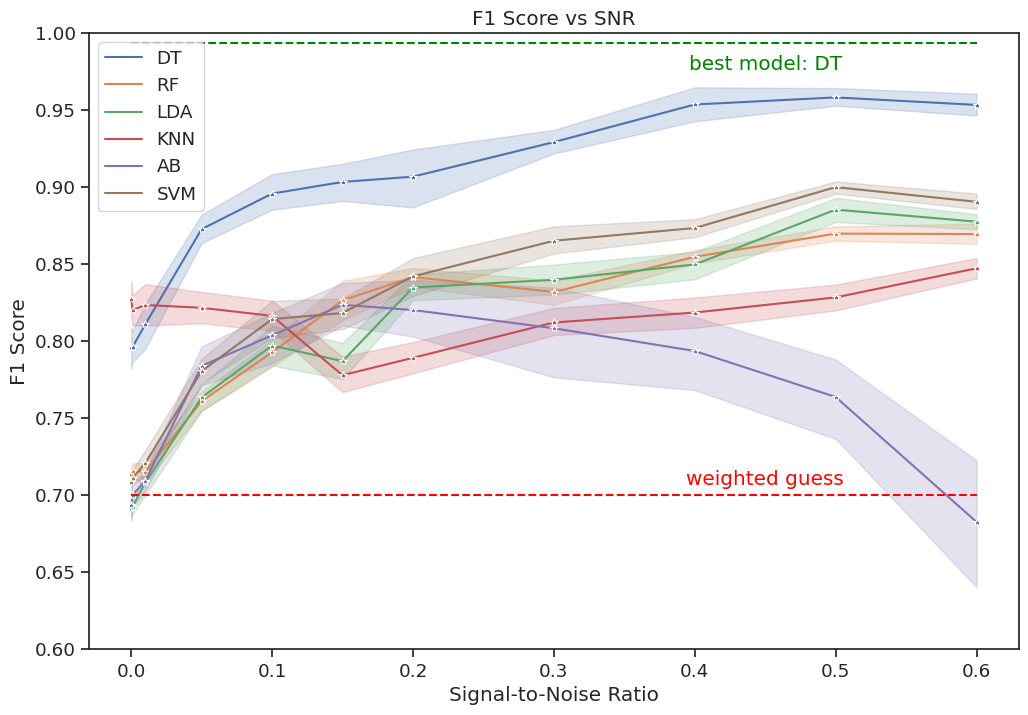

In [174]:
# subset.loc['mean']
# plt.errorbar(x=snrs, y=subset.loc['mean']['Accuracy'], yerr=subset.loc['std']['Accuracy'], fmt='o')
wesad_results, gn_wesad_results
# now plot same with seaborn
sns.set_theme(style="whitegrid")
sns.set_palette("Set2")
sns.set_context("paper")
sns.set(
    font_scale=1.2,
)
sns.set_style("ticks")
plt.figure(figsize=(12, 8))
ax = sns.lineplot(
    x="SNR", y="Binary F1", hue="Model", data=gn_wesad_results, marker='*'
)  # .set_title('GN-WESAD')
ax.hlines(
    y=wesad_results['Binary F1'].max(),
    xmin=0,
    xmax=0.6,
    linestyles='dashed',
    color='green',
)
ax.hlines(y=0.7, xmin=0, xmax=0.6, linestyles='dashed', color='red')
ax.set_title('F1 Score vs SNR')
ax.set_ylim([0.6, 1])
ax.set_xlabel('Signal-to-Noise Ratio'), ax.set_ylabel('F1 Score')
ax.text(x=0.45, y=0.71, s='weighted guess', color='red', va='center', ha='center')
ax.text(x=0.45, y=0.98, s='best model: DT', color='green', va='center', ha='center')
ax.legend(loc='upper left')

## Tabulate results 

In [175]:
if os.path.isfile(
    '/mnt/d/Users/alkurdi/data/w60s10_wesad_gn_combined_mean_performances.csv'
):
    print('file exists, will load it')
    combined_mean_performances = pd.read_csv(
        '/mnt/d/Users/alkurdi/data/w60s10_wesad_gn_combined_mean_performances.csv',
        index_col=0,
    )
else:
    current_df = pd.DataFrame(
        columns=[
            'SNR',
            'Accuracy',
            'F1 Score',
            'dataset',
            'n_i',
            'n',
            'noise gen function',
            'Precision',
            'Recall',
            'Model',
        ]
    )
    for snr in snrs:
        for model in fb_model_list:
            current = (
                gn_wesad_results.loc[
                    (gn_wesad_results['SNR'] == snr)
                    & (gn_wesad_results['Model'] == model)
                ]
                .mean()
                .to_frame()
                .T
            )
            current['Binary F1 stdv'] = gn_wesad_results.loc[
                (gn_wesad_results['SNR'] == snr) & (gn_wesad_results['Model'] == model)
            ].std()['Binary F1']
            current['Accuracy stdv'] = gn_wesad_results.loc[
                (gn_wesad_results['SNR'] == snr) & (gn_wesad_results['Model'] == model)
            ].std()['Accuracy']
            current['Model'] = model
            current['dataset'] = 'GN-WESAD'
            current['noise gen function'] = 'Gaussian Noise'
            current_df = pd.concat([current_df, current])
            # display(current)
    combined_mean_performances = pd.concat([wesad_results, current_df])
    combined_mean_performances.to_csv(
        'data/w60s10_wesad_gn_combined_mean_performances.csv'
    )

In [177]:
combined_mean_performances

,SNR,Accuracy,F1 Score,dataset,n_i,n,noise gen function,Precision,Recall,Model,Binary F1,Binary F1 stdv,Accuracy stdv
0,NaN,0.992548,0.992548,WESAD,1.0,1.0,None,0.992548,0.992548,DT,0.993498,NaN,NaN
1,NaN,0.910581,0.910581,WESAD,1.0,1.0,None,0.910581,0.910581,RF,0.93032,NaN,NaN
2,NaN,0.932936,0.932936,WESAD,1.0,1.0,None,0.932936,0.932936,LDA,0.948441,NaN,NaN
3,NaN,0.940387,0.940387,WESAD,1.0,1.0,None,0.940387,0.940387,KNN,0.955487,NaN,NaN
4,NaN,0.751118,0.751118,WESAD,1.0,1.0,None,0.751118,0.751118,AB,0.802609,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...
0,0.6,0.830532,0.830532,GN-WESAD,4.5,10.0,Gaussian Noise,0.830532,0.830532,RF,0.869615,0.011343,0.012403
0,0.6,0.853648,0.853648,GN-WESAD,4.5,10.0,Gaussian Noise,0.853648,0.853648,LDA,0.877631,0.008424,0.010742
0,0.6,0.794368,0.794368,GN-WESAD,4.5,10.0,Gaussian Noise,0.794368,0.794368,KNN,0.847376,0.011251,0.017323
0,NaN,NaN,NaN,GN-WESAD,NaN,NaN,Gaussian Noise,NaN,NaN,AdaBoost,NaN,NaN,NaN


## Feature Importances

In [ ]:
import scipy.stats as ss

for ft in range(0, len(ft_imp_matrix)):
    ft_imp_matrix[ft] = [
        sorted(ft_imp_matrix[ft], reverse=True).index(x) for x in ft_imp_matrix[ft]
    ]

In [ ]:
ft_imp_df = pd.DataFrame(ft_imp_matrix, columns=features)

In [ ]:
ft_imp_df.head()

In [ ]:
ft_imp_df.columns.values

In [ ]:
ft_imp_df.reset_index().pivot(index=ft_imp_df, columns=ft_imp_df.columns.values)

# E2E Models 

In [ ]:
e2e_path = 'delta_e2e_results/'
os.listdir(e2e_path)
for folder in os.listdir(e2e_path):
    for subfolder in os.listdir(e2e_path + folder):
        try:
            for subsub in os.listdir(e2e_path + folder + '/' + subfolder):
                try:
                    for subsubsub in os.listdir(
                        e2e_path + folder + '/' + subfolder + '/' + subsub
                    ):
                        print(
                            e2e_path
                            + folder
                            + '/'
                            + subfolder
                            + '/'
                            + subsub
                            + '/'
                            + subsubsub
                        )
                        # os.listdir(e2e_path+folder+'/'+subfolder)
                except:
                    print(
                        e2e_path
                        + folder
                        + '/'
                        + subfolder
                        + '/'
                        + subsub
                        + '/'
                        + subfolder
                    )
        except:
            print(e2e_path + folder + '/' + subfolder + '/' + subsub)

In [ ]:
import pandas as pd

path2 = '/mnt/d/Users/alkurdi/anxietyE2E/results_archive'

complete_results = pd.read_csv(path2 + '/complete_results.csv', index_col=0)

In [ ]:
goldenpath = "/mnt/d/Users/alkurdi/OneDrive - University of Illinois - Urbana/delta_old_results/e2e/e2e"
i = 0
book = {}
for root, dirs, files in os.walk(goldenpath):
    for file in files:
        if 'trials_objs' in root:
            break
        else:
            pass
        if 'complete_results' in file:
            i += 1
            # rt_splt = root.split('/')
            metrics = pd.read_csv(root + '/' + file, index_col=0)
            book[root] = metrics
            # print(rt_splt)
            # metrics['iter'] = int(rt_splt[-1][-2:])+1
            # metrics['fold'] = int(root[-2:])+1
            # metrics['tune'] = int(rt_splt[-3][-2:])+1
            # metrics['model'] = rt_splt[-2]
            # metrics['dataset'] = rt_splt[-4].split('_')[0]
            # print(rt_splt)
            # print(rt_splt[-5].split('_')[2])
            # print('snr', rt_splt[-5].split('_')[2])
print(i)

1


In [ ]:
# print(metrics)
print(list(book.keys()))
# book[list(book.keys())]

[]


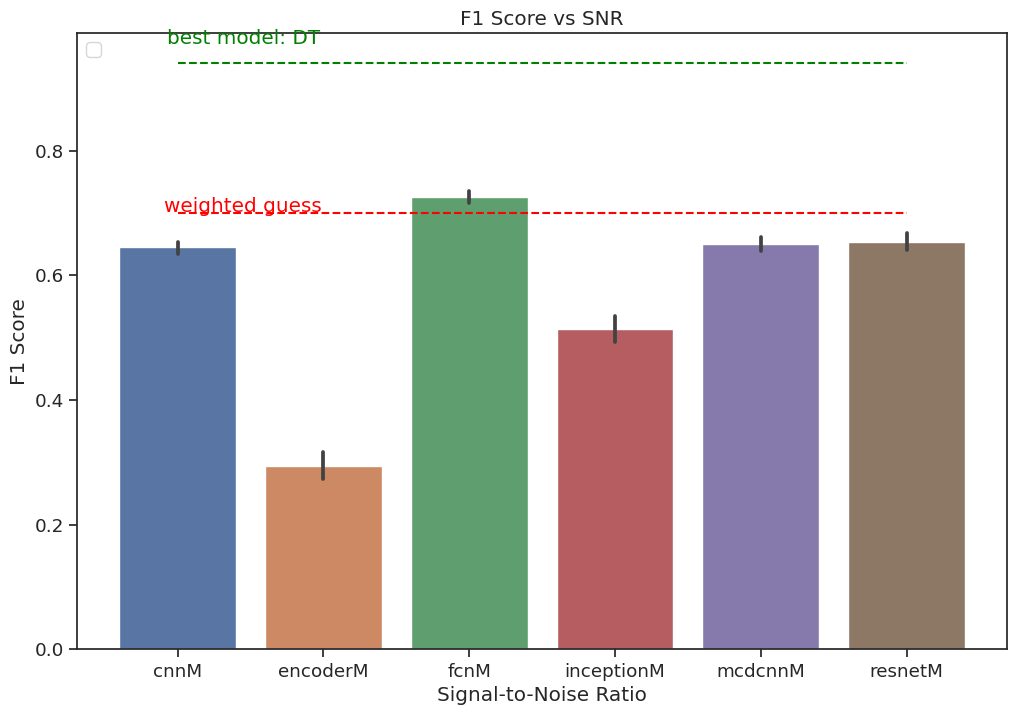

In [ ]:
# subset.loc['mean']
# plt.errorbar(x=snrs, y=subset.loc['mean']['Accuracy'], yerr=subset.loc['std']['Accuracy'], fmt='o')

# now plot same with seaborn
sns.set_theme(style="whitegrid")
sns.set_palette("Set2")
sns.set_context("paper")
sns.set(
    font_scale=1.2,
)
sns.set_style("ticks")
plt.figure(figsize=(12, 8))
ax = sns.barplot(x="model", y="f1", data=complete_results)
ax.hlines(
    y=complete_results['f1'].max(), xmin=0, xmax=5, linestyles='dashed', color='green'
)
ax.hlines(y=0.7, xmin=0, xmax=5, linestyles='dashed', color='red')
ax.set_title('F1 Score vs SNR')
# ax.set_ylim([0.6, 1])
ax.set_xlabel('Signal-to-Noise Ratio'), ax.set_ylabel('F1 Score')
ax.text(x=0.45, y=0.71, s='weighted guess', color='red', va='center', ha='center')
ax.text(x=0.45, y=0.98, s='best model: DT', color='green', va='center', ha='center')
ax.legend(loc='upper left')

In [ ]:
i = 0
# I need df_metrics
fileslist = []
for root, subfolders, filenames in os.walk(e2e_path):
    for filename in filenames:
        filepath = root + "/" + filename
        # print(filename[-4:])
        # do stuff with filepath
        if (
            ".hdf5" not in filename
            and '.txt' not in filename
            and '.lock' not in filename
            and '.pkl' not in filename
        ):
            fileslist.append(filename.split('.')[0])
            print(filepath)
            i += 1
print(i)

delta_e2e_results/e2e_copy2/results.py
delta_e2e_results/e2e_copy2/result_checking.py
delta_e2e_results/e2e_copy2/results/resultsForCriticalDiffrencesDiagram.csv
delta_e2e_results/e2e_copy2/results_snr_0.01/WESAD_5fold_00/tune_00/fcnM/it_00/df_best_model.csv
delta_e2e_results/e2e_copy2/results_snr_0.01/WESAD_5fold_00/tune_00/fcnM/it_00/df_metrics.csv
delta_e2e_results/e2e_copy2/results_snr_0.01/WESAD_5fold_00/tune_00/fcnM/it_00/epochs_loss.png
delta_e2e_results/e2e_copy2/results_snr_0.01/WESAD_5fold_00/tune_00/fcnM/it_00/history.csv
delta_e2e_results/e2e_copy2/results_snr_0.01/WESAD_5fold_00/tune_00/fcnM/it_00/predictions.png
delta_e2e_results/e2e_copy2/results_snr_0.01/WESAD_5fold_00/tune_00/fcnM/it_01/df_best_model.csv
delta_e2e_results/e2e_copy2/results_snr_0.01/WESAD_5fold_00/tune_00/fcnM/it_01/df_metrics.csv
delta_e2e_results/e2e_copy2/results_snr_0.01/WESAD_5fold_00/tune_00/fcnM/it_01/epochs_loss.png
delta_e2e_results/e2e_copy2/results_snr_0.01/WESAD_5fold_00/tune_00/fcnM/it_01/h

In [ ]:
import itertools

n_samples = 3
snrs = [1, 2, 3]
subject_ids = [1, 2, 3]
factor = [4]
list(itertools.product(list(range(n_samples)), snrs, subject_ids, factor))

[(0, 1, 1, 4),
 (0, 1, 2, 4),
 (0, 1, 3, 4),
 (0, 2, 1, 4),
 (0, 2, 2, 4),
 (0, 2, 3, 4),
 (0, 3, 1, 4),
 (0, 3, 2, 4),
 (0, 3, 3, 4),
 (1, 1, 1, 4),
 (1, 1, 2, 4),
 (1, 1, 3, 4),
 (1, 2, 1, 4),
 (1, 2, 2, 4),
 (1, 2, 3, 4),
 (1, 3, 1, 4),
 (1, 3, 2, 4),
 (1, 3, 3, 4),
 (2, 1, 1, 4),
 (2, 1, 2, 4),
 (2, 1, 3, 4),
 (2, 2, 1, 4),
 (2, 2, 2, 4),
 (2, 2, 3, 4),
 (2, 3, 1, 4),
 (2, 3, 2, 4),
 (2, 3, 3, 4)]